# Classification

This notebook performs a comprehensive classification analysis on a credit card dataset and a food recommendation dataset. We start by cleaning the credit card data and transforming the response variable. Next, we build and interpret a decision tree classifier, including tree pruning to avoid overfitting. We then compare its performance with several Random Forest models by testing different numbers of estimators, evaluating accuracy, cross-validation scores, and feature importance. Finally, we construct a recommendation system using a decision tree on McDonald’s food data to suggest similar items based on nutritional attributes.

In [19]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv('CreditCardData.csv')

In [21]:
df

,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43,560,+
2,a,24.5,0.500,u,g,q,h,1.50,t,f,0,f,g,280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,260,0,-
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,200,394,-
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,200,1,-
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,280,750,-


### 1) Need to clean the data. Remove all the rows which have any missing values in any column (missing data is represented as ? and not nan/null so you need to keep this in mind)

In [22]:
df = df.replace('?', np.nan)
df = df.dropna()
#df.iloc[86]

### 2. Replace the Approved column (response variable) values from -/+ to 0/1 or No/Yes based on your preference.

In [23]:
df['Approved'] = df['Approved'].str.replace( '-' ,'No')
df['Approved'] = df['Approved'].str.replace( '+' ,'Yes')
#df.iloc [1]
#df.iloc[86]
df

,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202,0,Yes
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43,560,Yes
2,a,24.5,0.500,u,g,q,h,1.50,t,f,0,f,g,280,824,Yes
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100,3,Yes
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,b,21.08,10.085,y,p,e,h,1.25,f,f,0,f,g,260,0,No
686,a,22.67,0.750,u,g,c,v,2.00,f,t,2,t,g,200,394,No
687,a,25.25,13.500,y,p,ff,ff,2.00,f,t,1,t,g,200,1,No
688,b,17.92,0.205,u,g,aa,v,0.04,f,f,0,f,g,280,750,No


### 3. Create a train and test set after cleaning the data. Use 30% (0.3) records for test set. Use the same train and test set for all your analysis with different classifiers.
### 4. In your code, set the seed after you read the data. This will keep your data and calculation consistent throughout the analysis irrespective of multiple runs. See the example code for the class random_state=99

In [24]:
seed = 99
# this is to convert categorical data to one-hot data
one_hot = pd.get_dummies(df, columns = ['Male', 'Married', 'BankCustomer', 'EducationLevel', 'Ethnicity', 'PriorDefault', 'Employed', 'DriversLicense', 'Citizen' ])
one_hot

,Age,Debt,YearsEmployed,CreditScore,ZipCode,Income,Approved,Male_a,Male_b,Married_l,...,Ethnicity_z,PriorDefault_f,PriorDefault_t,Employed_f,Employed_t,DriversLicense_f,DriversLicense_t,Citizen_g,Citizen_p,Citizen_s
0,30.83,0.000,1.25,1,202,0,Yes,False,True,False,...,False,False,True,False,True,True,False,True,False,False
1,58.67,4.460,3.04,6,43,560,Yes,True,False,False,...,False,False,True,False,True,True,False,True,False,False
2,24.5,0.500,1.50,0,280,824,Yes,True,False,False,...,False,False,True,True,False,True,False,True,False,False
3,27.83,1.540,3.75,5,100,3,Yes,False,True,False,...,False,False,True,False,True,False,True,True,False,False
4,20.17,5.625,1.71,0,120,0,Yes,False,True,False,...,False,False,True,True,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,21.08,10.085,1.25,0,260,0,No,False,True,False,...,False,True,False,True,False,True,False,True,False,False
686,22.67,0.750,2.00,2,200,394,No,True,False,False,...,False,True,False,False,True,False,True,True,False,False
687,25.25,13.500,2.00,1,200,1,No,True,False,False,...,False,True,False,False,True,False,True,True,False,False
688,17.92,0.205,0.04,0,280,750,No,False,True,False,...,False,True,False,True,False,True,False,True,False,False


In [25]:
X = one_hot.drop(['Approved'],axis=1)
Y = one_hot['Approved']

In [26]:
X_train, X_test, y_train, y_testdt = train_test_split(X, Y, test_size=0.3, random_state= seed)

In [27]:
X_train.head()

,Age,Debt,YearsEmployed,CreditScore,ZipCode,Income,Male_a,Male_b,Married_l,Married_u,...,Ethnicity_z,PriorDefault_f,PriorDefault_t,Employed_f,Employed_t,DriversLicense_f,DriversLicense_t,Citizen_g,Citizen_p,Citizen_s
422,29.42,1.250,1.750,0,200,0,False,True,False,True,...,False,True,False,True,False,True,False,True,False,False
269,18,0.165,0.210,0,200,40,False,True,False,True,...,False,True,False,True,False,True,False,True,False,False
167,32.33,0.540,0.040,0,440,11177,True,False,False,True,...,False,False,True,True,False,True,False,True,False,False
355,16,0.165,1.000,2,320,1,True,False,False,True,...,False,True,False,False,True,False,True,True,False,False
660,22.25,9.000,0.085,0,0,0,False,True,False,True,...,False,True,False,True,False,True,False,True,False,False


In [28]:
y_train.head()

422     No
269    Yes
167    Yes
355     No
660     No
Name: Approved, dtype: object

### 5.Create a classification model to predict Approved status using Decision Tree. Visualize the decision tree. Interpret the decision tree. Discuss which attributes are important and which are not important. 
### 6. Perform the Tree Pruning Analysis and evaluate the results. Visualize the tree after pruning. Discuss the tree and overall results before and after pruning.

In [29]:
dt = tree.DecisionTreeClassifier(random_state= seed)

In [30]:
dtmodel = dt.fit(X_train,y_train)

In [31]:
train_pred = dtmodel.predict (X_train)

In [32]:
train_pred

array(['No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes',
       'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No',
       'No', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No',
       'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No',
       'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes',
       'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes',
       'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes',
       'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No',
       'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'No',
       'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'No',
       'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes',
       'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes',
       'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No', '

In [33]:
accuracy = accuracy_score(train_pred, y_train)
accuracy*100

100.0

In [34]:
test_preddt = dtmodel.predict(X_test)
test_preddt

array(['Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes',
       'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No',
       'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'Yes',
       'Yes', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes',
       'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes',
       'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No',
       'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No',
       'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes',
       'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes',
       'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No',
       'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'No',
       'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No'

In [35]:
accuracy = accuracy_score(test_preddt, y_testdt)
accuracy*100

84.18367346938776

Our model has a 100% training accuracy, which indicates that the training data have caused the model to overfit.
In addition, the test accuracy is 84.18%, and we were able to predict the values of the Approved feature for 30% of the dataset that the model missed.

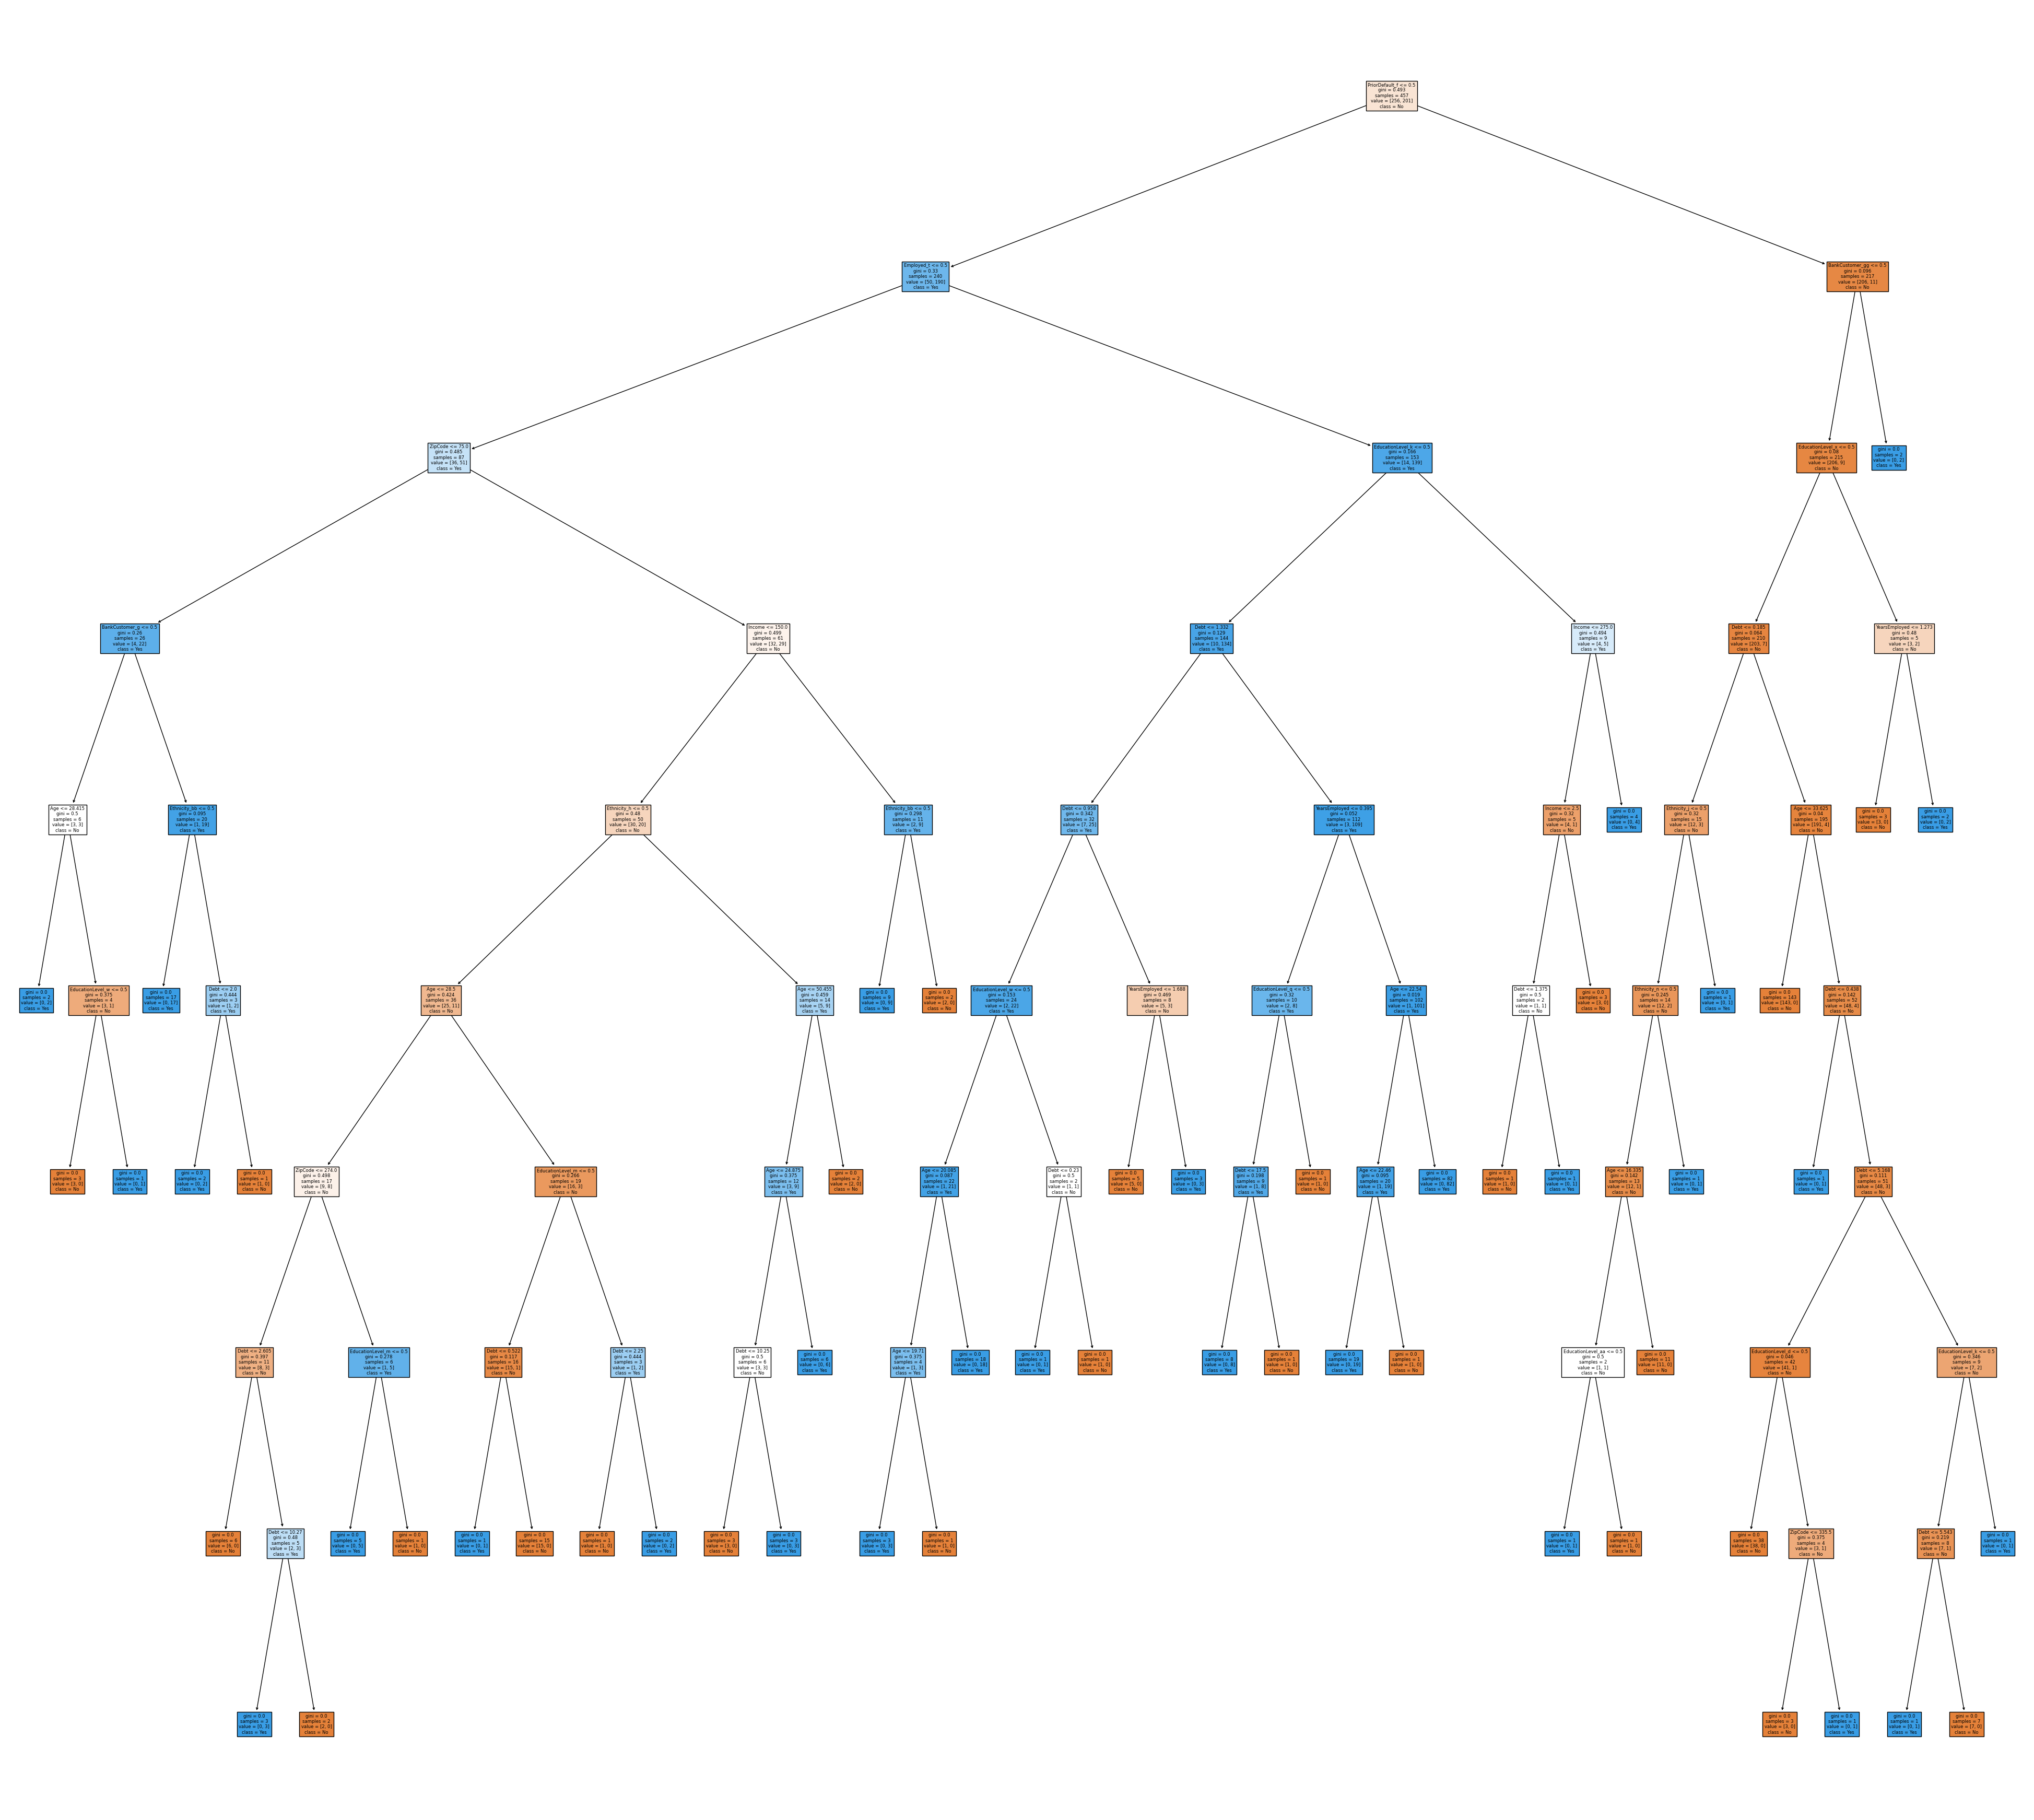

In [36]:
fig = plt.figure(figsize=(50,45))
_ = tree.plot_tree(dtmodel, 
                   feature_names=list(X.columns),  
                   class_names=Y.value_counts().index,
                   filled=True)

The PriorDefault characteristic is the very first one to be listed in the decision tree. This indicates that the value of the Approved feature is primarily determined by PriorDefault(most significant).
Age, EducationLevel, and Male_b, on the other hand, are the least significant and are located at the bottom of the decision tree. They don't matter all that much in figuring out how valuable the Approved feature is.

### Pruning helped increasing the accuracy on test data

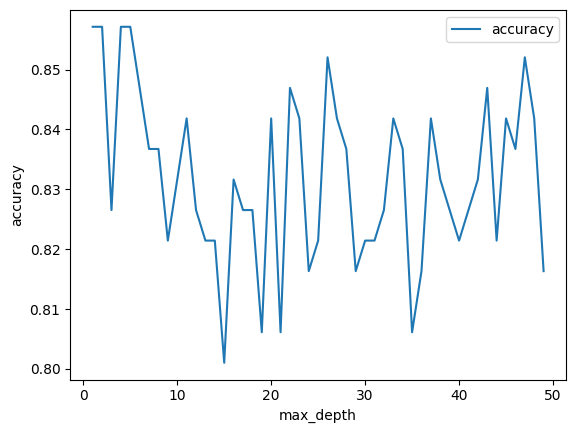

In [37]:
max_depth = []
acc = []
for i in range(1,50):
    dtree = tree.DecisionTreeClassifier(criterion='gini',max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc.append(accuracy_score(y_testdt, pred))
    max_depth.append(i)
    
d = pd.DataFrame({'accuracy':pd.Series(acc),'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','accuracy', data=d)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()

In [38]:
dt = tree.DecisionTreeClassifier(criterion='gini',max_depth=12)
dtmodel = dt.fit(X_train, y_train)
train_pred1 = dtmodel.predict(X_train)

In [39]:
acc = accuracy_score(train_pred1, y_train)
acc*100

100.0

In [40]:
test_pred1 = dtmodel.predict(X_test)
test_pred1

array(['Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes',
       'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No',
       'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No',
       'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes',
       'Yes', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'Yes',
       'Yes', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes',
       'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No',
       'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No',
       'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'No', 'No',
       'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes',
       'Yes', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes',
       'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'No', 'No',
       'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'No',
       'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'No',


In [41]:
acc = accuracy_score(test_pred1, y_testdt)
acc*100

82.14285714285714

In [42]:
scores_dt = cross_val_score(dtmodel, X, Y, cv=5)
scores_dt.mean()

0.7963358778625954

The accuracy of the test data is now at 80.6%.  
The overfitting nature of the model is the same we have an accuracy of 100% for the training set.  
The overall accuracy of the model is 80%.

### 7. Create a classification model to predict Approved status using RandomForest. Include all the analysis steps including variable importance plot. Try atleast 5 different values of n_estimators (number of trees) and compare the classification error. Pick the best model (based on n_estimators) for your final comparison.

In [43]:
# 1) When n_estimator's value is 100:
rf = RandomForestClassifier(n_estimators=100)

In [44]:
rfmodel = rf.fit(X_train, y_train)
train_pred = rfmodel.predict(X_train)
acc = accuracy_score(train_pred, y_train)
acc*100

100.0

In [45]:
test_pred = rfmodel.predict(X_test)
acc = accuracy_score(test_pred, y_testdt)
acc*100

86.22448979591837

In [46]:
rfmodel.feature_importances_

array([5.55035935e-02, 5.75281100e-02, 8.77356038e-02, 4.65474044e-02,
       6.24269268e-02, 5.66720395e-02, 7.87404976e-03, 8.37663024e-03,
       1.48388796e-03, 8.07815351e-03, 5.50968759e-03, 8.26366278e-03,
       2.02868992e-03, 8.16479576e-03, 6.45726602e-03, 8.60958811e-03,
       6.86035160e-03, 2.06251530e-03, 2.04978369e-03, 8.15206404e-03,
       4.76558751e-03, 3.71608828e-04, 1.12001649e-02, 3.32910282e-03,
       6.79914643e-03, 4.97190435e-05, 6.98449453e-03, 1.08459769e-02,
       6.48567642e-03, 6.04155260e-05, 6.71759957e-03, 1.49794005e-02,
       1.60015764e-03, 2.22563697e-03, 2.48599536e-04, 8.16828874e-03,
       8.35710368e-04, 1.78044572e-01, 1.71561844e-01, 4.60576076e-02,
       4.10035417e-02, 7.30119787e-03, 9.19920693e-03, 5.14363106e-03,
       1.08548557e-03, 4.55082238e-03])

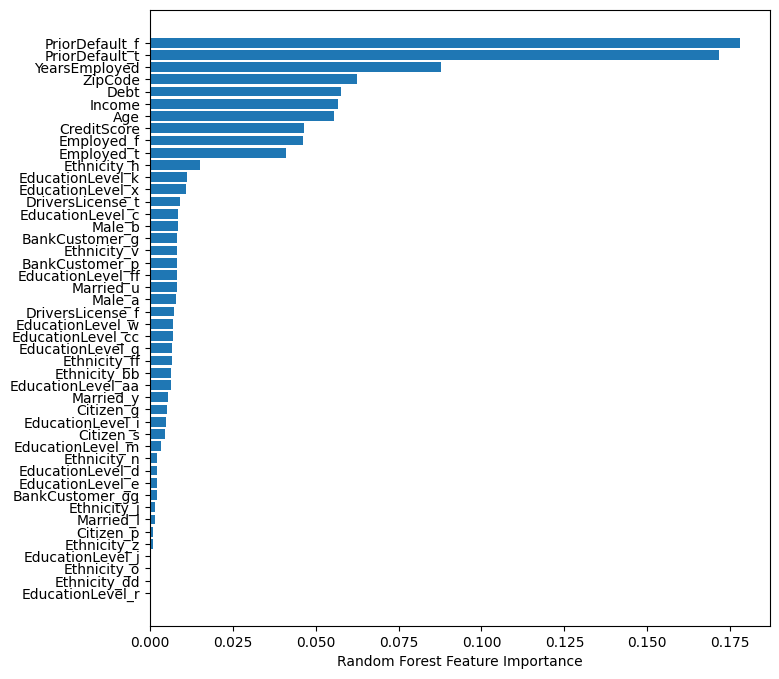

In [47]:
sorted_idx = rfmodel.feature_importances_.argsort()
bar = plt.figure()
plt.barh(list(X.columns[sorted_idx]), rfmodel.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
bar.set_figwidth(8)
bar.set_figheight(8)

In [48]:
scores = cross_val_score(rfmodel, X, Y, cv=5)
scores

array([0.65648855, 0.97709924, 0.93129771, 0.74615385, 0.91538462])

In [49]:
scores.mean()

0.8452847915443336

In [50]:
cm = confusion_matrix(y_train,train_pred)
cm

array([[256,   0],
       [  0, 201]], dtype=int64)

In [51]:
cm2 = confusion_matrix(y_testdt,test_pred)
cm2

array([[88, 13],
       [14, 81]], dtype=int64)

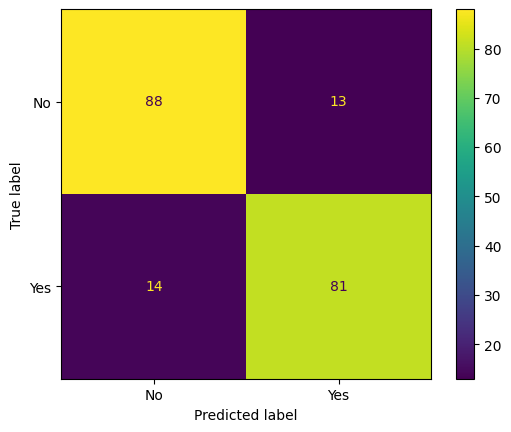

In [52]:
cp = ConfusionMatrixDisplay(cm2,display_labels=rfmodel.classes_)
cp.plot()

With 100 estimators, the training accuracy is 100%, and the test accuracy is 86.7%.
With an importance value of 0.175, the Random Forest's PriorDefault feature is the most crucial.
The accuracy of cross validation is 84.9%.

In [53]:
# 2) When n_estimator's value is 80:
rf = RandomForestClassifier(n_estimators=80)

In [54]:
rfmodel = rf.fit(X_train, y_train)
train_pred = rfmodel.predict(X_train)
acc = accuracy_score(train_pred, y_train)
acc*100

100.0

In [55]:
test_pred = rfmodel.predict(X_test)
acc = accuracy_score(test_pred, y_testdt)
acc*100

88.26530612244898

In [56]:
rfmodel.feature_importances_

array([5.89066387e-02, 5.93551701e-02, 8.02587586e-02, 5.54029132e-02,
       6.31799965e-02, 5.09342227e-02, 1.02233753e-02, 9.18615148e-03,
       2.82261066e-03, 7.30686879e-03, 6.96606809e-03, 7.42363423e-03,
       1.12796317e-03, 7.88848488e-03, 5.63789898e-03, 8.10233349e-03,
       9.21427570e-03, 2.35781976e-03, 8.71581831e-04, 7.25970463e-03,
       8.98155138e-03, 4.84624091e-04, 9.01949519e-03, 3.41491236e-03,
       8.87543798e-03, 2.29372389e-04, 5.98453940e-03, 1.26753060e-02,
       6.44784060e-03, 1.67819448e-04, 6.04530821e-03, 1.74861607e-02,
       1.35985358e-03, 2.10919917e-03, 8.05704902e-04, 9.46835681e-03,
       9.13737902e-04, 1.57239957e-01, 1.81302327e-01, 4.49755882e-02,
       4.01149983e-02, 7.89672738e-03, 8.22541043e-03, 5.44410617e-03,
       1.02144716e-03, 4.88374741e-03])

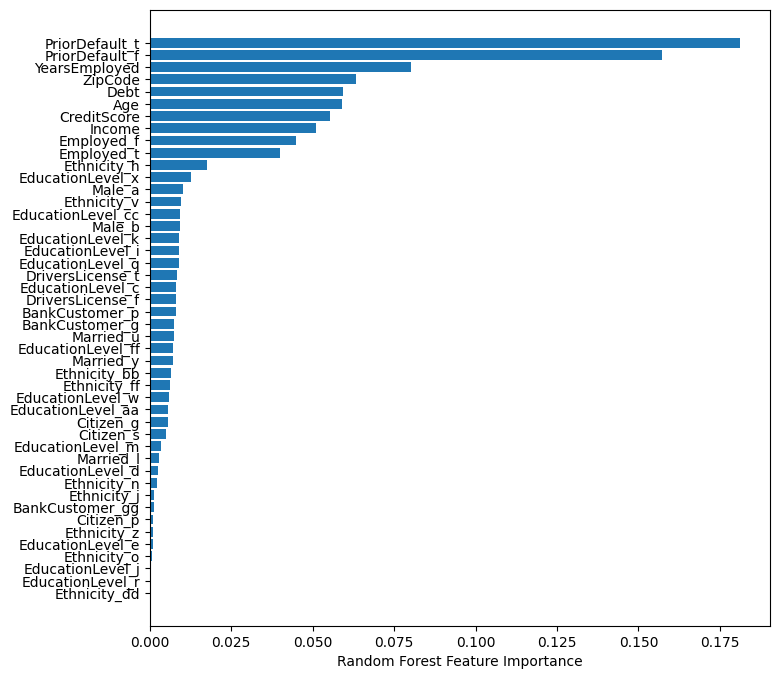

In [57]:
sorted_idx = rfmodel.feature_importances_.argsort()
bar = plt.figure()
plt.barh(list(X.columns[sorted_idx]), rfmodel.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
bar.set_figwidth(8)
bar.set_figheight(8)

In [58]:
scores = cross_val_score(rfmodel, X, Y, cv=5)
scores

array([0.65648855, 0.96946565, 0.94656489, 0.76153846, 0.92307692])

In [59]:
scores.mean()

0.8514268937169701

In [60]:
cm = confusion_matrix(y_train,train_pred)
cm

array([[256,   0],
       [  0, 201]], dtype=int64)

In [61]:
cm2 = confusion_matrix(y_testdt,test_pred)
cm2

array([[89, 12],
       [11, 84]], dtype=int64)

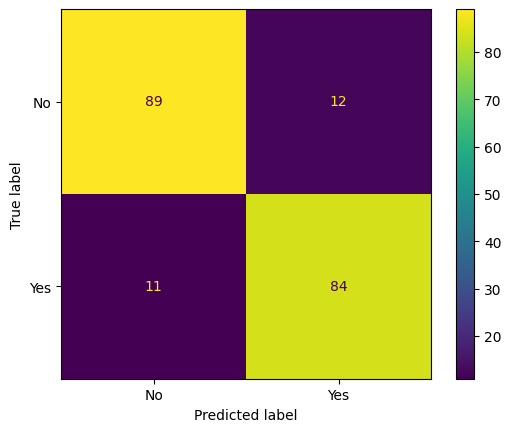

In [62]:
cp = ConfusionMatrixDisplay(cm2,display_labels=rfmodel.classes_)
cp.plot()

With 80 estimators, the training accuracy is 100%, and the test accuracy is 87.2%.
With an importance value of 0.175, the Random Forest's PriorDefault feature is the most crucial.
The accuracy of cross validation is 84.68%.


In [63]:
# 3) When n_estimator's value is 60:
rf = RandomForestClassifier(n_estimators=60)

In [64]:
rfmodel = rf.fit(X_train, y_train)
train_pred = rfmodel.predict(X_train)
acc = accuracy_score(train_pred, y_train)
acc*100

100.0

In [65]:
test_pred = rfmodel.predict(X_test)
acc = accuracy_score(test_pred, y_testdt)
acc*100

86.73469387755102

In [66]:
rfmodel.feature_importances_

array([5.48987171e-02, 6.02352359e-02, 7.39845372e-02, 8.90569860e-02,
       5.67766790e-02, 6.69113686e-02, 6.93803681e-03, 8.72708019e-03,
       1.30202467e-03, 6.28473587e-03, 7.13736106e-03, 8.20045324e-03,
       2.99216716e-03, 5.03923417e-03, 4.40914850e-03, 8.16240119e-03,
       7.42928268e-03, 3.26806929e-03, 1.52193282e-03, 8.44021195e-03,
       6.39064667e-03, 2.12486717e-04, 9.26166505e-03, 3.05719284e-03,
       7.96134379e-03, 0.00000000e+00, 6.64952234e-03, 7.05402501e-03,
       4.70649823e-03, 4.03579045e-05, 6.72222407e-03, 1.74305566e-02,
       1.98532851e-03, 2.45795348e-03, 2.73881844e-04, 7.16603715e-03,
       3.67945609e-04, 1.77708713e-01, 1.58201653e-01, 3.41738715e-02,
       4.16007705e-02, 5.95530336e-03, 8.01119474e-03, 5.66561780e-03,
       1.60524624e-03, 3.62430044e-03])

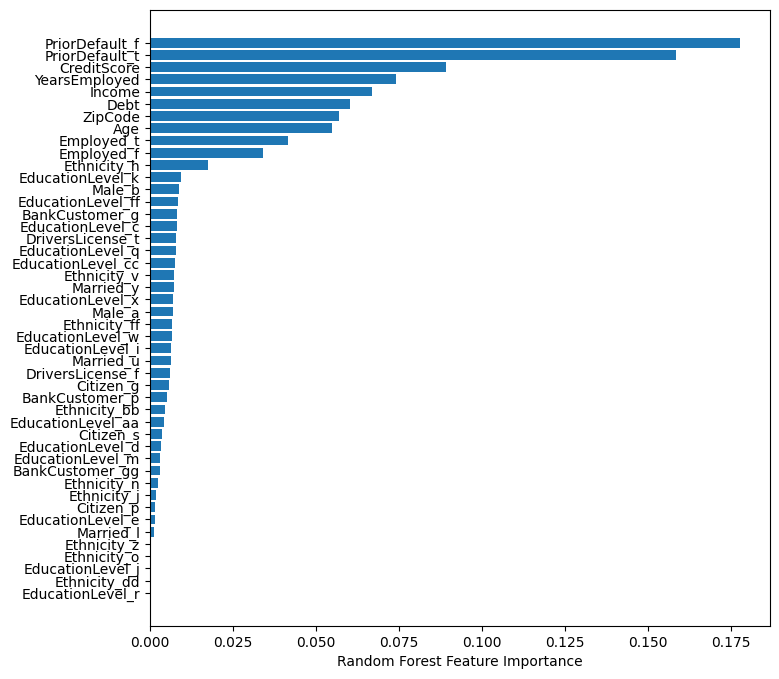

In [67]:
sorted_idx = rfmodel.feature_importances_.argsort()
bar = plt.figure()
plt.barh(list(X.columns[sorted_idx]), rfmodel.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
bar.set_figwidth(8)
bar.set_figheight(8)

In [68]:
scores = cross_val_score(rfmodel, X, Y, cv=5)
scores

array([0.66412214, 0.98473282, 0.94656489, 0.76923077, 0.91538462])

In [69]:
scores.mean()

0.8560070463887259

In [70]:
cm = confusion_matrix(y_train,train_pred)
cm

array([[256,   0],
       [  0, 201]], dtype=int64)

In [71]:
cm2 = confusion_matrix(y_testdt,test_pred)
cm2

array([[89, 12],
       [14, 81]], dtype=int64)

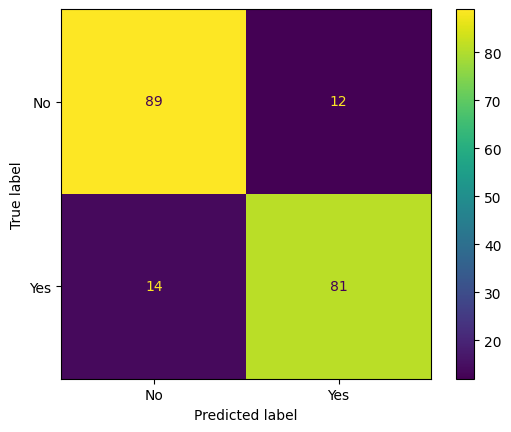

In [72]:
cp = ConfusionMatrixDisplay(cm2,display_labels=rfmodel.classes_)
cp.plot()

With 60 estimators, the training accuracy is 100%, and the test accuracy is 85.73%.
With an importance value of 0.175, the Random Forest's PriorDefault feature is the most crucial.
The accuracy of cross validation is 84.67%.

In [73]:
# 4) When n_estimator's value is 120:
rf = RandomForestClassifier(n_estimators=120)

In [74]:
rfmodel = rf.fit(X_train, y_train)
train_pred = rfmodel.predict(X_train)
acc = accuracy_score(train_pred, y_train)
acc*100

100.0

In [75]:
test_pred = rfmodel.predict(X_test)
acc = accuracy_score(test_pred, y_testdt)
acc*100

86.73469387755102

In [76]:
rfmodel.feature_importances_

array([5.69084424e-02, 5.67365390e-02, 7.70553470e-02, 7.64173564e-02,
       5.64920473e-02, 5.43086315e-02, 8.87600164e-03, 6.11799616e-03,
       3.01530226e-03, 6.52036927e-03, 6.91581991e-03, 6.75337633e-03,
       2.97708814e-03, 6.86370197e-03, 5.33874381e-03, 6.84283868e-03,
       8.82459479e-03, 3.27683449e-03, 1.38892526e-03, 6.56406179e-03,
       5.39854051e-03, 2.47974505e-04, 9.07920677e-03, 3.65885130e-03,
       6.98441667e-03, 8.58193920e-05, 7.67608039e-03, 1.17789903e-02,
       6.00413757e-03, 1.16580398e-04, 8.02143661e-03, 1.55704524e-02,
       1.85860234e-03, 2.97807397e-03, 8.36980853e-04, 9.47106320e-03,
       9.59357385e-04, 1.79435490e-01, 1.74171988e-01, 3.59808600e-02,
       3.62945574e-02, 7.90076377e-03, 6.88670333e-03, 4.64431525e-03,
       6.46311154e-04, 5.11842888e-03])

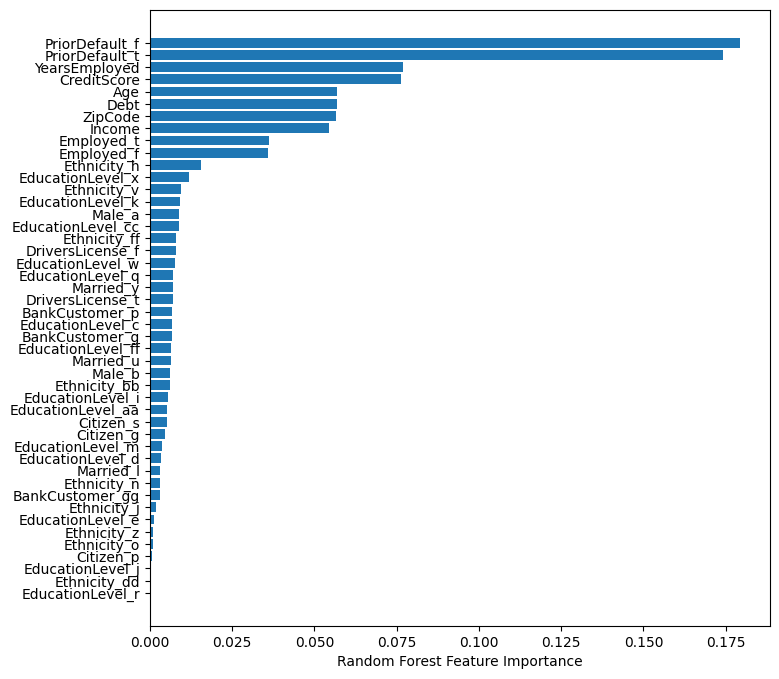

In [77]:
sorted_idx = rfmodel.feature_importances_.argsort()
bar = plt.figure()
plt.barh(list(X.columns[sorted_idx]), rfmodel.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
bar.set_figwidth(8)
bar.set_figheight(8)

In [78]:
scores = cross_val_score(rfmodel, X, Y, cv=5)
scores

array([0.65648855, 0.96183206, 0.94656489, 0.76153846, 0.92307692])

In [79]:
scores.mean()

0.8499001761597181

In [80]:
cm = confusion_matrix(y_train,train_pred)
cm

array([[256,   0],
       [  0, 201]], dtype=int64)

In [81]:
cm2 = confusion_matrix(y_testdt,test_pred)
cm2

array([[89, 12],
       [14, 81]], dtype=int64)

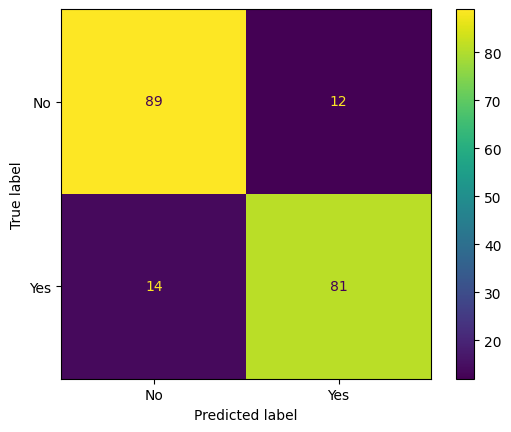

In [82]:
cp = ConfusionMatrixDisplay(cm2,display_labels=rfmodel.classes_)
cp.plot()

With 120 estimators, the training accuracy is 100%, and the test accuracy is 87.2%.
With an importance value of 0.175, the Random Forest's PriorDefault feature is the most crucial.
The accuracy of cross validation is 84.5%.

In [83]:
# 5) When n_estimator's value is 150:
rf = RandomForestClassifier(n_estimators=150)

In [84]:
rfmodel = rf.fit(X_train, y_train)
train_pred = rfmodel.predict(X_train)
acc = accuracy_score(train_pred, y_train)
acc*100

100.0

In [85]:
test_pred = rfmodel.predict(X_test)
acc = accuracy_score(test_pred, y_testdt)
acc*100

85.20408163265306

In [86]:
rfmodel.feature_importances_

array([5.42123298e-02, 5.30931687e-02, 6.91888617e-02, 7.03592837e-02,
       5.85546620e-02, 5.64923313e-02, 7.80943029e-03, 8.37506128e-03,
       2.59074841e-03, 7.30976039e-03, 6.93498119e-03, 6.47075883e-03,
       1.51894450e-03, 6.03400113e-03, 5.63585276e-03, 8.33977822e-03,
       7.57084187e-03, 3.30644941e-03, 1.75271101e-03, 6.96036024e-03,
       4.93155331e-03, 2.89694386e-04, 1.01532941e-02, 3.56106823e-03,
       8.92914467e-03, 1.66031443e-04, 7.27808463e-03, 1.50551881e-02,
       4.45629745e-03, 3.19328066e-04, 6.44052155e-03, 1.92386283e-02,
       1.89948542e-03, 2.54947949e-03, 7.81509687e-04, 7.54448301e-03,
       3.71364233e-04, 1.59277417e-01, 2.00188513e-01, 3.06015404e-02,
       4.55498168e-02, 8.89424393e-03, 8.29027800e-03, 5.40577118e-03,
       1.15723172e-03, 4.15971485e-03])

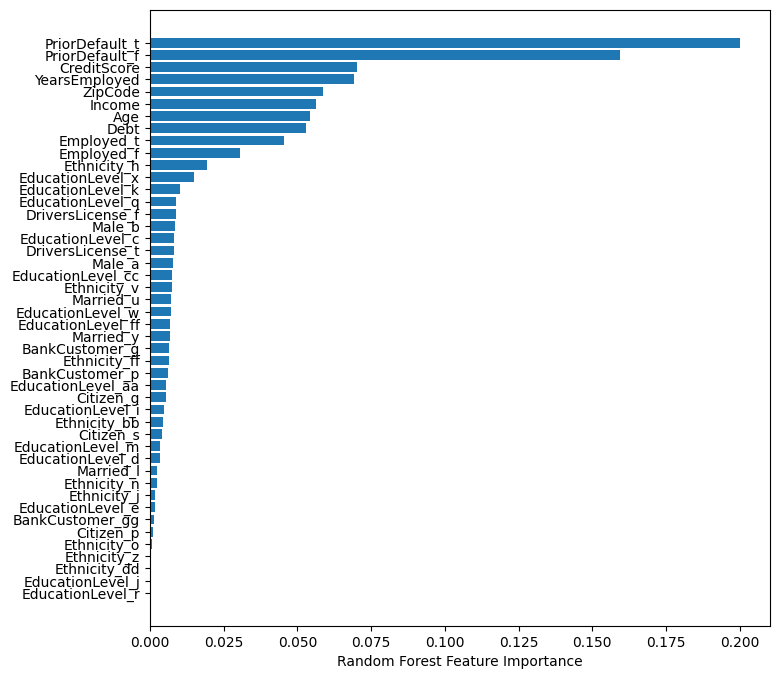

In [87]:
sorted_idx = rfmodel.feature_importances_.argsort()
bar = plt.figure()
plt.barh(list(X.columns[sorted_idx]), rfmodel.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
bar.set_figwidth(8)
bar.set_figheight(8)

In [88]:
scores = cross_val_score(rfmodel, X, Y, cv=5)
scores

array([0.65648855, 0.97709924, 0.94656489, 0.74615385, 0.92307692])

In [89]:
scores.mean()

0.8498766881972989

In [90]:
cm = confusion_matrix(y_train,train_pred)
cm

array([[256,   0],
       [  0, 201]], dtype=int64)

In [91]:
cm2 = confusion_matrix(y_testdt,test_pred)
cm2

array([[88, 13],
       [16, 79]], dtype=int64)

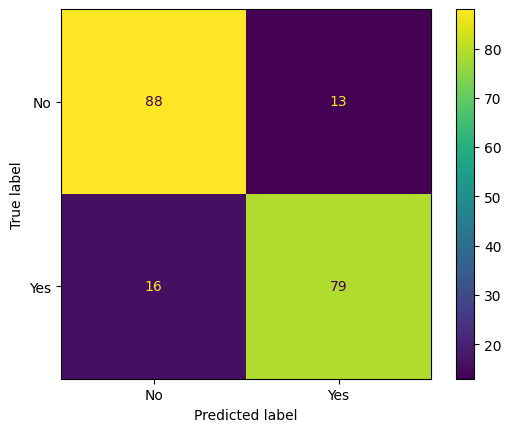

In [92]:
cp = ConfusionMatrixDisplay(cm2,display_labels=rfmodel.classes_)
cp.plot()


With 150 estimators, the training accuracy is 100%, and the test accuracy is 87.75%.
With an importance value of 0.175, the Random Forest's PriorDefault feature is the most crucial.
The accuracy of cross validation is 85.44%.



### 7. Report the comparison between Decision Tree and RandomForest in terms of classification performance.

Text(0.5, 1.0, 'Confusion Matrix - Decision Tree')

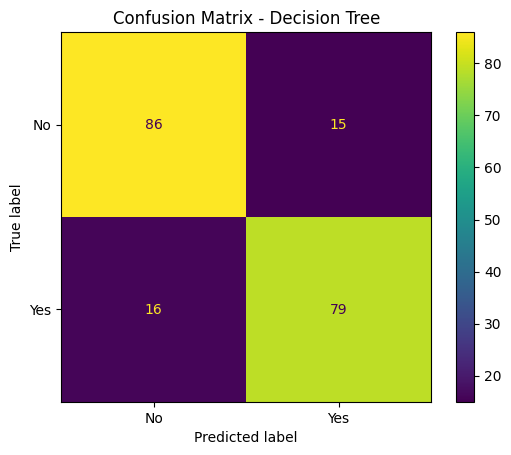

In [93]:
dt_cm = confusion_matrix(y_testdt, test_preddt)
dt_cp = ConfusionMatrixDisplay(dt_cm, display_labels = dtmodel.classes_)
dt_cp.plot()
dt_cp.ax_.set_title("Confusion Matrix - Decision Tree")

Text(0.5, 1.0, 'Confusion Matrix - Random Forest')

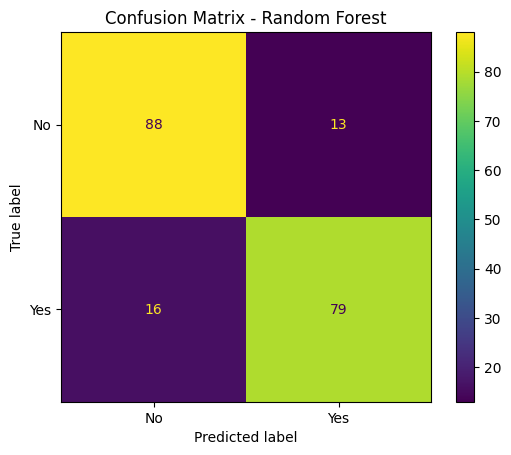

In [94]:
rf_cm = confusion_matrix(y_testdt, test_pred)
rf_cp = ConfusionMatrixDisplay(rf_cm, display_labels = rfmodel.classes_)
rf_cp.plot()
rf_cp.ax_.set_title("Confusion Matrix - Random Forest")

These confusion matrices show that the Random Forest is more accurate than the Decision Tree and generates fewer false predictions.
For instance:
1. The Random Forest wrongly forecasts the label "1" as "0" only 15 times compared to the Decision Tree's 16 times.
2. The Random Forest wrongly forecasts the label "0" as "1" only 12 times compared to the Decision Tree's 15 times.

Moreover, Random Forest tree with 150 estimators will be chosen as it has the highest overall accuracy result than other models. We also observe that random forest tree accuracy is greater than decision tree. 

## Recommendation using mcdonalds.csv
### 1. Build a decision tree to recommend similar food based on their attributes. Interpret your decision tree and tell some interesting insights from it. You do not (necessarily) need to pick all the food (rows) and attributes (columns). Just pick 3 similar food items of your choice and explain/interpret your recommendations. Note: You need to remove restaurant column first from the data before creating a decision tree.

In [95]:
df2 = pd.read_csv('mcdonalds.csv')

In [96]:
df2

,restaurant,item,calories,cal_fat,total_fat,sat_fat,cholesterol,sodium,total_carb,fiber,sugar,protein,vit_a,vit_c,calcium
0,Mcdonalds,Artisan Grilled Chicken Sandwich,380,60,7,2.0,95,1110,44,3,11,37,4,20,20
1,Mcdonalds,Grilled Bacon Smokehouse Chicken Sandwich,750,280,31,10.0,155,1940,62,2,18,55,6,25,20
2,Mcdonalds,Crispy Bacon Smokehouse Chicken Sandwich,920,410,45,12.0,120,1980,81,4,18,46,6,20,20
3,Mcdonalds,Big Mac,540,250,28,10.0,80,950,46,3,9,25,10,2,15
4,Mcdonalds,Cheeseburger,300,100,12,5.0,40,680,33,2,7,15,10,2,10
5,Mcdonalds,Classic Chicken Sandwich,510,210,24,4.0,65,1040,49,3,6,25,0,4,2
6,Mcdonalds,Filet-O-Fish,380,170,18,4.0,40,640,38,2,5,15,2,0,15
7,Mcdonalds,Hamburger,250,70,8,3.0,30,480,31,2,6,13,2,2,4
8,Mcdonalds,Lobster Roll,290,50,5,1.5,65,630,35,2,3,24,4,6,15
9,Mcdonalds,McChicken,350,130,15,3.5,40,600,40,2,5,15,2,2,4


In [97]:
DfX = df2.drop(['restaurant','item'],axis=1)
DfY = df2['item']

In [98]:
dt2 = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=2, min_samples_leaf=1,random_state=99)

In [99]:
dtmodel2 = dt2.fit(DfX, DfY)

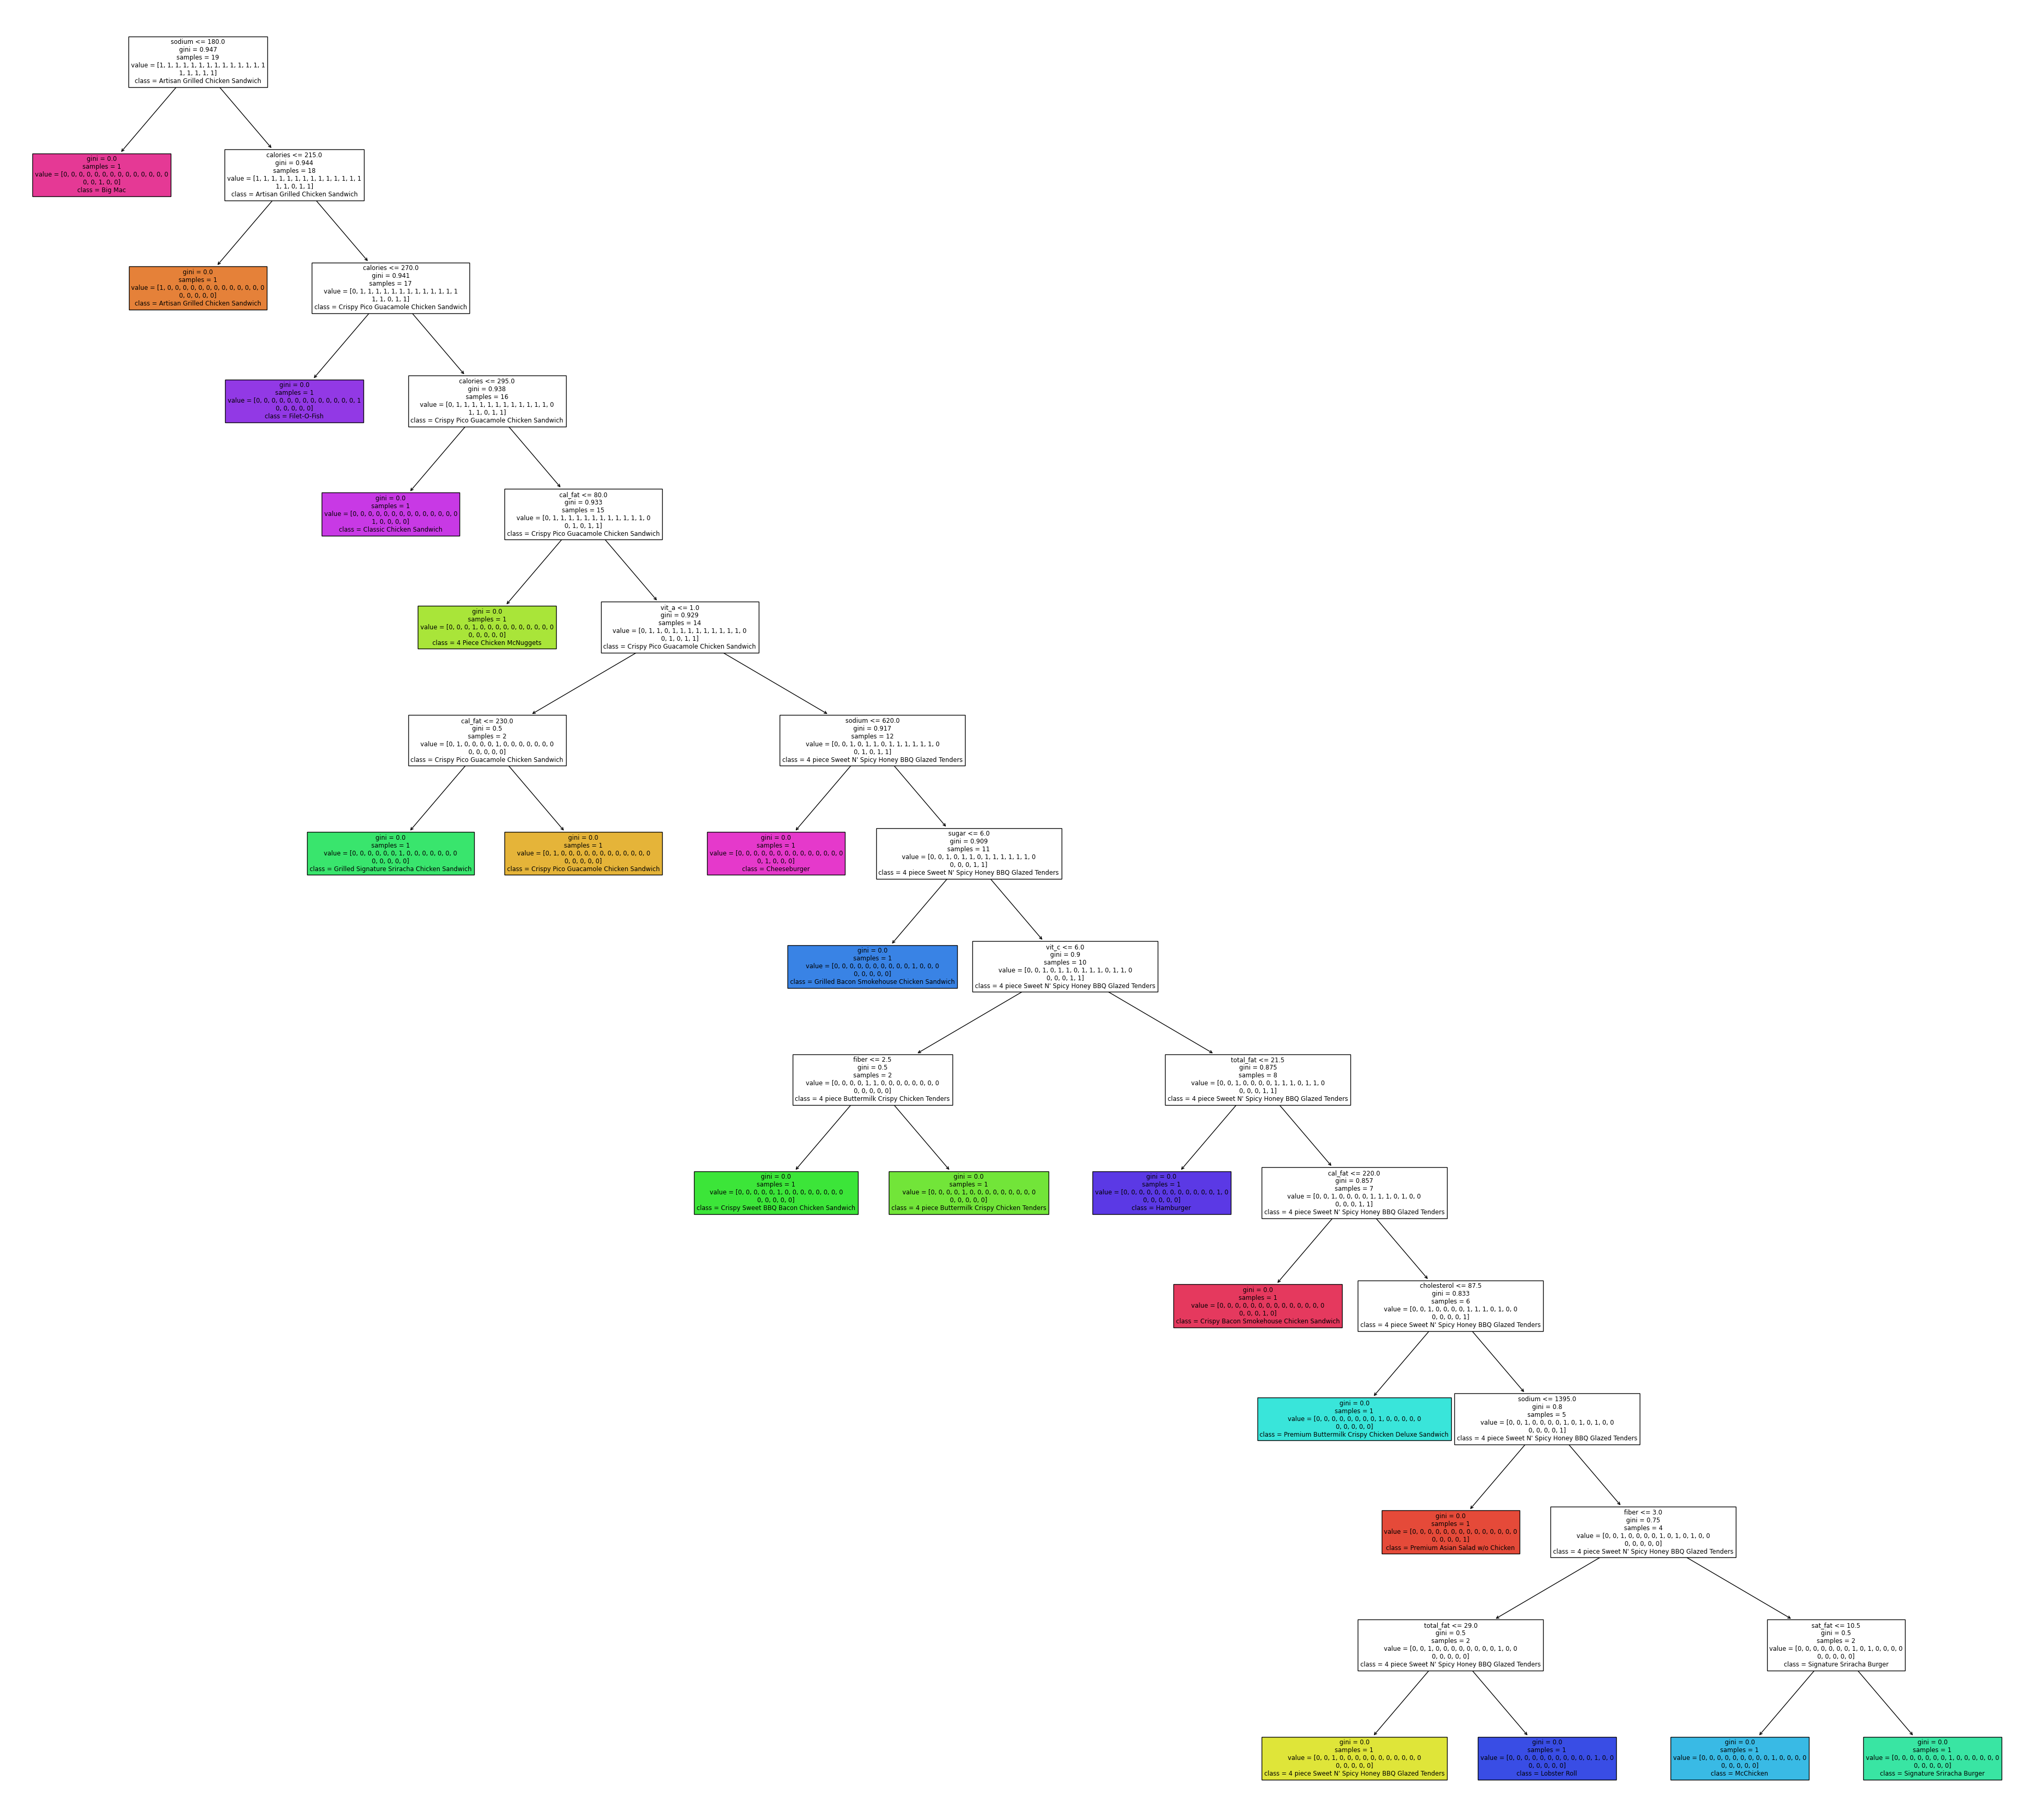

In [100]:
fig = plt.figure(figsize=(50,45))
_ = tree.plot_tree(dtmodel2, 
                   feature_names=list(DfX.columns),  
                   class_names=DfY.value_counts().index,
                   filled=True)

The top of the decision tree lists sodium as the most important factor to take into account while choosing the dietary products.
total_fat and sat_fat are the least important component.
Now, we will compare Crispy sweet BBq bacon chicken sandwich (CSBBCS), 4 piece Buttermilk Crispy Chicken Tenders(4PBCCT) and Hamburgers which are somehow similair to each other as per the tree given above. 
CSBBCS has 36 total fat, 20 vitamin C and 5 fiber while 4PBCCT has 28 total fat, 0 vitamin C and 0 fiber, however, Hamburgers have 8 total fat and 2 both fibers and vitamin C level. Moreover, Hamburger has the least cholestrole out of these three food items and thus It would a good choice as it has least total fat and cholestrol than other two choices.